In [40]:
import os

# Set the environment variable
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"


In [41]:
import pandas as pd
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
import argparse
import wandb
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, train_test_split


In [42]:
wandb.login()

True

In [43]:
if torch.backends.mps.is_available() :
    device = 'mps'
elif torch.cuda.is_available():
    device = 'cuda'

device

'mps'

In [44]:
cfg = {
    "BATCH_SIZE": 256,
    "LR": 1e-3,
    "VAL_AFTER": 1,
    "LOSS": nn.BCEWithLogitsLoss(),
    "WEIGHT_DECAY": 0,#9.230632893415364e-05,
    "DROP": 0.8,
    "AUG": 0.0,
    "GAMMA": 0.9,
    # "DEVICE": "cuda:0",
    "DEVICE": device,
    "PATIENCE": 50,
    "EPOCHS": 150,
}
csv_file = 'fc_colab.csv'

In [45]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="trial",
    name = 'cc200 fft1'
    # track hyperparameters and run metadata
    # config={
    # "learning_rate": cfg[LR],
    
    # }
)

## DataLoader

In [46]:
from torch.utils.data import Dataset



class SingleAtlas(Dataset):
    def __init__(self, df, augment=0.0):
        self.df = df
        self.augment = augment

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        x = torch.tensor(np.loadtxt(self.df.iloc[idx].cc200)).float()

        if(np.random.rand() > self.augment):
            x +=torch.rand_like(x) * 0.01

        x = (x-x.mean()) / x.std()

        label = torch.tensor([self.df.iloc[idx].LABELS])
        label = torch.eye(2)[label].float().squeeze()

        return x, label
    
class MultiAtlas(Dataset):
    def __init__(self, df, augment=0.0):
        self.df = df
        self.augment = augment

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        aal = torch.tensor(np.loadtxt(self.df.iloc[idx].aal)).float()
        cc200 = torch.tensor(np.loadtxt(self.df.iloc[idx].cc200)).float()
        dos160 = torch.tensor(np.loadtxt(self.df.iloc[idx].dosenbach160)).float()

        if np.random.rand() > self.augment:
            aal += torch.randn_like(aal) * 0.01
            cc200 += torch.randn_like(cc200) * 0.01
            dos160 += torch.randn_like(dos160) * 0.01

        aal = (aal - aal.mean()) / aal.std()
        cc200 = (cc200 - cc200.mean()) / cc200.std()
        dos160 = (dos160 - dos160.mean()) / dos160.std()

        label = torch.tensor([self.df.iloc[idx].LABELS])
        label = torch.eye(2)[label].float().squeeze()

        return (aal, cc200, dos160), label


class ImputationDataset(Dataset):
    def __init__(self, df, mask_ratio=0.0):
        self.df = df
        self.mask_ratio = mask_ratio

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        aal = torch.tensor(np.loadtxt(self.df.iloc[idx].aal)).float()
        cc200 = torch.tensor(np.loadtxt(self.df.iloc[idx].cc200)).float()
        dos160 = torch.tensor(np.loadtxt(
            self.df.iloc[idx].dosenbach160)).float()

        aal = (aal - aal.mean()) / aal.std()
        cc200 = (cc200 - cc200.mean()) / cc200.std()
        dos160 = (dos160 - dos160.mean()) / dos160.std()

        # generate mask where self.mask_ratio is 1 else 0
        aal_mask = torch.tensor(np.random.choice(
            [0, 1], size=aal.shape, p=[1-self.mask_ratio, self.mask_ratio]))
        cc200_mask = torch.tensor(np.random.choice(
            [0, 1], size=cc200.shape, p=[1-self.mask_ratio, self.mask_ratio]))
        dos160_mask = torch.tensor(np.random.choice(
            [0, 1], size=dos160.shape, p=[1-self.mask_ratio, self.mask_ratio]))

        # note that torch multihead attention requires mask to be 0 where attention is applied
        aal_masked = aal * ~aal_mask
        cc200_masked = cc200 * ~cc200_mask
        dos160_masked = dos160 * ~dos160_mask

        return (aal, cc200, dos160),  (aal_masked, cc200_masked, dos160_masked),(aal_mask, cc200_mask, dos160_mask)


## Utils

In [47]:
import copy
import numpy as np
import torch
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score,precision_score, recall_score, roc_auc_score, f1_score
import torch.nn.functional as F
import torch.nn as nn


In [48]:
## for SAT cc200


class MaskedMSELoss(nn.Module):
    """ Masked MSE Loss
        from https://github.com/gzerveas/mvts_transformer/blob/3f2e378bc77d02e82a44671f20cf15bc7761671a/src/models/loss.py
    """

    def __init__(self, reduction: str = 'mean'):

        super().__init__()

        self.reduction = reduction
        self.mse_loss = nn.MSELoss(reduction=self.reduction)

    def forward(self,
                y_pred: torch.Tensor, y_true: torch.Tensor, mask: torch.BoolTensor) -> torch.Tensor:
        """Compute the loss between a target value and a prediction.

        Args:
            y_pred: Estimated values
            y_true: Target values
            mask: boolean tensor with 0s at places where values should be ignored and 1s where they should be considered

        Returns
        -------
        if reduction == 'none':
            (num_active,) Loss for each active batch element as a tensor with gradient attached.
        if reduction == 'mean':
            scalar mean loss over batch as a tensor with gradient attached.
        """
        return self.mse_loss(y_pred, y_true)

def train(model, train_loader, val_loader, criterion, optimizer, epochs, device,stage ,patience, scheduler=None, return_best_acc=False):

    early_stopping = True if patience else False
    losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_acc = 0
    counter = 0
    current_epoch = 0
    early_stopping_flag = 0

    ##
    ###
    epochs_list = []  # List to store epochs
    train_losses_list = []  # List to store training losses
    val_losses_list = []  # List to store validation losses

    train_acc_list = []
    val_acc_list = []  # List to store accuracies

    train_precision_list = []
    val_precision_list = []

    train_recall_list = []
    val_recall_list = []

    train_f1_list = []
    val_f1_list = []

    train_auc_list = []
    val_auc_list = []
    

    fig, axs = plt.subplots(3, 2, figsize=(12, 15))
    with tqdm(range(current_epoch, epochs), unit="epoch") as tepoch:
        for i in tepoch:
            epochs_list.append(i)
    
            tepoch.set_description(f"Epoch {i}")
            epoch_losses = []
            ytrain_true = []
            ytrain_pred = []
            ytrain_predprob = []
            train_running_loss = 0.0
            model.train()
            for i, (inputs, labels) in enumerate(train_loader):
    
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                train_running_loss += loss.item()

                ytrain_true.extend(
                        np.argmax(labels.detach().cpu().numpy(), axis=1))

                yp = outputs.detach().cpu().numpy()
                ytrain_pred.extend(np.argmax(np.where(yp > 0.5, 1, 0), axis=1))

                loss.backward()
                optimizer.step()

                
                epoch_losses.append(loss.item())
            if scheduler:
                scheduler.step()
            
            losses.extend(epoch_losses)
            
            train_loss = train_running_loss / len(train_loader)
            train_acc = accuracy_score(ytrain_true, ytrain_pred)
            train_precision = precision_score(ytrain_true, ytrain_pred, average='weighted')
            train_recall = recall_score(ytrain_true, ytrain_pred, average='weighted')
            train_auc = roc_auc_score(ytrain_true, ytrain_pred, average='weighted', multi_class='ovo')
            train_f1 = f1_score(ytrain_true, ytrain_pred, average='weighted')
            
            train_losses_list.append(train_running_loss/len(train_loader))
            train_acc_list.append(train_acc)
            train_precision_list.append(train_precision)
            train_recall_list.append(train_recall)
            train_auc_list.append(train_auc)
            train_f1_list.append(train_f1)

            tepoch.set_postfix(loss=f"{train_running_loss/len(train_loader)}", acc=f"{train_acc}")

            model.eval()
            with torch.no_grad():
                val_running_loss = 0.0
                y_true, y_pred, y_predprob = [], [], []
                for inputs, labels in val_loader:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    val_loss = criterion(outputs, labels)
                    val_running_loss += val_loss.item()

                    val_losses.append(val_loss.item())
                    y_true.extend(
                        np.argmax(labels.detach().cpu().numpy(), axis=1))

                    yp = outputs.detach().cpu().numpy()
                    y_pred.extend(np.argmax(np.where(yp > 0.5, 1, 0), axis=1))

                    y_pred_prob = outputs.detach().cpu().numpy()
                    y_predprob.extend(y_pred_prob)

                avg_val_loss = val_running_loss / len(val_loader)
                val_losses_list.append(val_running_loss/len(val_loader))

                val_acc = accuracy_score(y_true, y_pred)
                val_precision = precision_score(y_true, y_pred, average='weighted')
                val_recall = recall_score(y_true, y_pred, average='weighted')
                val_auc = roc_auc_score(y_true, y_pred, average='weighted', multi_class='ovo')
                val_f1 = f1_score(y_true, y_pred, average='weighted')
                    
                val_acc_list.append(val_acc)
                val_precision_list.append(val_precision)
                val_recall_list.append(val_recall)
                val_auc_list.append(val_auc)
                val_f1_list.append(val_f1)

                wandb.log({ "Train Loss": train_loss, 
                            "Train Accuracy": train_acc, 
                            "Train Precision": train_precision,
                            "Train Recall": train_recall,
                            "Train F1-Score": train_f1,
                            "Train AUC": train_auc,
                            "Test Loss": avg_val_loss, 
                            "Test Accuracy": val_acc, 
                            "Test Precision": val_precision,
                            "Test Recall": val_recall,
                            "Test F1-Score": val_f1,
                            "Test AUC": val_auc,
                        
                        })
            
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = copy.deepcopy(model)
                counter = 0
            else:
                counter += 1
                if early_stopping and counter >= patience:
                    print("Early stopping!")
                    break
            if val_acc > best_acc:
                best_acc = val_acc
            
            ##
            if early_stopping_flag == 1:
                return best_model, best_acc if return_best_acc else best_model

    print(f"best acc: {best_acc}")
    metrics_list = [["Loss", "losses"], 
                    ["Accuracy", 'acc'], 
                    ["Precision",'precision'],
                    ["Recall", 'recall'], 
                    ["F1-score", 'f1'], 
                    ["AUC", 'auc' ]]
    for i, metric in enumerate(metrics_list):
        row = i // 2
        col = i % 2
        ax = axs[row, col]

        ax.set_title(metric[0])
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric[0])

        # Plot training and validation curves for the metric
        ax.plot(epochs_list, eval(f'train_{metric[1]}_list'), label="Training")
        ax.plot(epochs_list, eval(f'val_{metric[1]}_list'), label="Validation")

        ax.legend()

    
    plt.tight_layout()
    plt.show()
    ###
    ##

    return best_model, best_acc if return_best_acc else best_model


def test(model, test_loader, device):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            y_true.extend(np.argmax(targets.detach().cpu().numpy(), axis=1))
            yp = F.softmax(outputs, dim=1).detach().cpu().numpy()
            y_pred.extend(np.argmax(np.where(yp > 0.5, 1, 0), axis=1))
    return y_true, y_pred


## Model

In [49]:
import math
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.modules.module import Module


class SAT(nn.Module):
    def __init__(self, feat_dim=19900, d_model=128, dim_feedforward=128, num_encoder_layers=2, num_heads=8, dropout=0.1):
        super().__init__()
        self.feat_dim = feat_dim
        self.d_model = d_model
        self.dim_feedforward = dim_feedforward
        self.num_encoder_layers = num_encoder_layers
        self.num_heads = num_heads
        self.dropout = dropout

        self.encoder = EncoderBlock(
            feat_dim, d_model, dim_feedforward, num_encoder_layers, num_heads, dropout)
        self.act = nn.GELU()
        self.do = nn.Dropout(p=dropout)
        self.head = nn.Linear(d_model, 2)

    def forward(self, x):
        x = self.encoder(x)
        x = self.act(x)
        # x = self.do(x)
        x = self.head(x)

        return x
    
class METAWrapper(nn.Module):
    def __init__(self, d_model=128, dim_feedforward=128, num_encoder_layers=2, num_heads=8, dropout=0.1, init_weights=False):
        super().__init__()
        self.d_model = d_model
        self.dim_feedforward = dim_feedforward
        self.num_encoder_layers = num_encoder_layers
        self.num_heads = num_heads
        self.dropout = dropout

        self.cc200_encoder = EncoderBlock(
            19900, d_model, dim_feedforward, num_encoder_layers, num_heads, dropout)
        
        self.cc200_act = nn.GELU()
        self.cc200_do = nn.Dropout(dropout)
        self.cc200_head = nn.Linear(d_model, 19900)
        
    def forward(self,cc200, cc200_mask):

        
        cc200 = self.cc200_encoder(cc200, cc200_mask)
        cc200 = self.cc200_act(cc200)
        cc200 = self.cc200_do(cc200)
        cc200 = self.cc200_head(cc200)
    
        return cc200


class EncoderBlock(nn.Module):
    def __init__(self, input_dim, d_model, n_heads, num_encoder_layers, dim_feedforward, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.inp_emb = nn.Linear(input_dim, d_model)
        # encoder_layer = nn.TransformerEncoderLayer(
        #     d_model, n_heads, dim_feedforward, dropout=dropout, activation="gelu")
        self.encoder = FNet(d_model,dim_feedforward,num_encoder_layers,
                            dropout=dropout,activation="gelu")

    def forward(self, x, mask=None):
        
        x = self.inp_emb(x) / math.sqrt(self.d_model)
        x = self.encoder(x)
        return x

# ********************fnet ***************#

class FeedForward(Module):
    def __init__(self, dim, hidden_dim, activation ,dropout =0,  ):
        super().__init__()
        self.linear1 = nn.Linear(in_features=dim, out_features=hidden_dim, bias = True)
        self.dropout = nn.Dropout(p=dropout, inplace=False)
        # self.linear2 = nn.Linear(in_features=hidden_dim*2, out_features=hidden_dim, bias=True)
        self.linear3 = nn.Linear(in_features=hidden_dim, out_features=dim, bias=True)

        self.dropout1 = nn.Dropout(p=dropout, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout, inplace=False)
        self.norm1 = nn.LayerNorm(dim,  eps=1e-05,elementwise_affine=True)
        self.norm2 = nn.LayerNorm(dim,  eps=1e-05,elementwise_affine=True)

        # Legacy string support for activation function.
        if isinstance(activation, str):
            if activation == 'relu':
                activation = F.relu
            elif activation == 'gelu':
                activation = F.gelu

        # We can't test self.activation in forward() in TorchScript,
        # so stash some information about it instead.
        if activation is F.relu or isinstance(activation, torch.nn.ReLU):
            self.activation_relu_or_gelu = 1
        elif activation is F.gelu or isinstance(activation, torch.nn.GELU):
            self.activation_relu_or_gelu = 2
        else:
            self.activation_relu_or_gelu = 0
        self.activation = activation

    def __setstate__(self, state):
        super().__setstate__(state)
        if not hasattr(self, 'activation'):
            self.activation = F.relu
    def forward(self, x):
        x = self.dropout(self.activation(self.linear1(x)))
        # x = self.dropout(self.activation(self.linear2(x)))
        x = self.dropout(self.activation(self.linear3(x)))

        x = self.norm1(x)
        x = self.norm2(x)
        x = self.dropout1(x)
        x = self.dropout2(x)
        return x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x)+x, **kwargs)
        

class FNetBlock(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    x = torch.fft.fft(x, dim=-1).real
    return x
  

class FNet(nn.Module):
    def __init__(self, d_model,  dim_feedforward,num_encoder_layers, dropout,activation):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(num_encoder_layers):
            self.layers.append(nn.ModuleList([
                PreNorm(d_model, FNetBlock()),
                PreNorm(d_model, FeedForward(d_model, dim_feedforward, activation, dropout = dropout)),
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x


In [50]:
def pretrain_train_cross_validate(file):

    device = cfg["DEVICE"]

    df = pd.read_csv(file)

    # cross validation
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    y = df.LABELS
    x = df.drop("LABELS", axis=1)
    accs = []

    table_cols = ['Fold','Num_fnet_layers', 'Accuracy', 'Precision', 'Recall',
                  'F1', 'AUC', 'AP', 'FPR', 'FNR', 'TPR', 'TNR']

    vals = []
    dim_feedforward = 128

    for fold, (train_idx, test_idx) in enumerate(kfold.split(x, y)):

        with wandb.init(project="trial", name ='cc200 fft1' ,config={"fold": fold}):
            print(80 * "=")
            print(f"Fold {fold}")
            print(80 * "=")

            enc_layer = 2

            print()
            print(f'number of encoded layers: {enc_layer}')
            print("=="*50)

            train_df = df.iloc[train_idx]
            test_df = df.iloc[test_idx]


            train_loader = DataLoader(SingleAtlas(
                train_df, augment=0.3), batch_size=cfg["BATCH_SIZE"], shuffle=True, num_workers=0, pin_memory=True)
       
            test_loader = DataLoader(SingleAtlas(
                test_df, augment=0), batch_size=cfg["BATCH_SIZE"], shuffle=False, num_workers=0, pin_memory=True)

            # Pretrain
            pretrain_loader = DataLoader(ImputationDataset(
                train_df), batch_size=cfg["BATCH_SIZE"], shuffle=True, num_workers=0, pin_memory=True)
            preval_loader = DataLoader(ImputationDataset(
                test_df), batch_size=cfg["BATCH_SIZE"], shuffle=False, num_workers=0, pin_memory=True)

            pt_model = METAWrapper(d_model=256, dim_feedforward=dim_feedforward, num_encoder_layers=enc_layer,
                                num_heads=4, dropout=cfg["DROP"]).to(cfg["DEVICE"])

            pt_optim = optim.AdamW(pt_model.parameters(),
                                lr=1e-3, weight_decay=0)

            print("Pretraining finished...")

            # Load pretrained weights
            model = SAT(d_model=512, dim_feedforward=dim_feedforward, num_encoder_layers=enc_layer,
                            num_heads=4, dropout=cfg["DROP"]).to(cfg["DEVICE"])

            optimizer = optim.AdamW(
                model.parameters(), lr=1e-4, weight_decay=0)

            scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
            criterion = nn.BCEWithLogitsLoss().to(cfg["DEVICE"])

            start = time.time()

            trained_model, best_a = train(model, train_loader, test_loader, criterion, optimizer,
                                            cfg['EPOCHS'], device,stage = f"fnet_train_{fold}", patience=False, scheduler=scheduler, return_best_acc=True)

            end = time.time()
            # Test
            print("Testing...")
            trues, preds = test(trained_model, test_loader, device)

            acc = accuracy_score(trues, preds)
            accs.append(acc)
            cm = confusion_matrix(trues, preds)
            precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
            recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
            f1 = 2 * (precision * recall) / (precision + recall)
            auc = roc_auc_score(trues, preds)
            ap = average_precision_score(trues, preds)
            fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])
            fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])
            tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0])
            tnr = cm[0, 0] / (cm[0, 0] + cm[0, 1])

            print(f"Training time taken with pretrain : {end - start}")
            print(f"Fold {fold}: Accuracy: {acc}")
            print(f"Fold {fold}: Confusion matrix:\n{cm}")
        

            vals.append([fold, enc_layer, acc, precision, recall,
                        f1, auc, ap, fpr, fnr, tpr, tnr])

                    
    wandb.finish()
    results = pd.DataFrame(vals, columns=table_cols)
    print(results)
    results.to_csv('results_wb_cc200_fft1.csv', index=False)
    print(80 * "=")
    print(f"Mean accuracy: {np.mean(accs)}")
    print(f"Std accuracy: {np.std(accs)}")


Fold 0

number of encoded layers: 2
Pretraining finished...


Epoch 149: 100%|██████████| 150/150 [03:35<00:00,  1.43s/epoch, acc=0.9975845410628019, loss=0.013077284586586302]


best acc: 0.6763285024154589


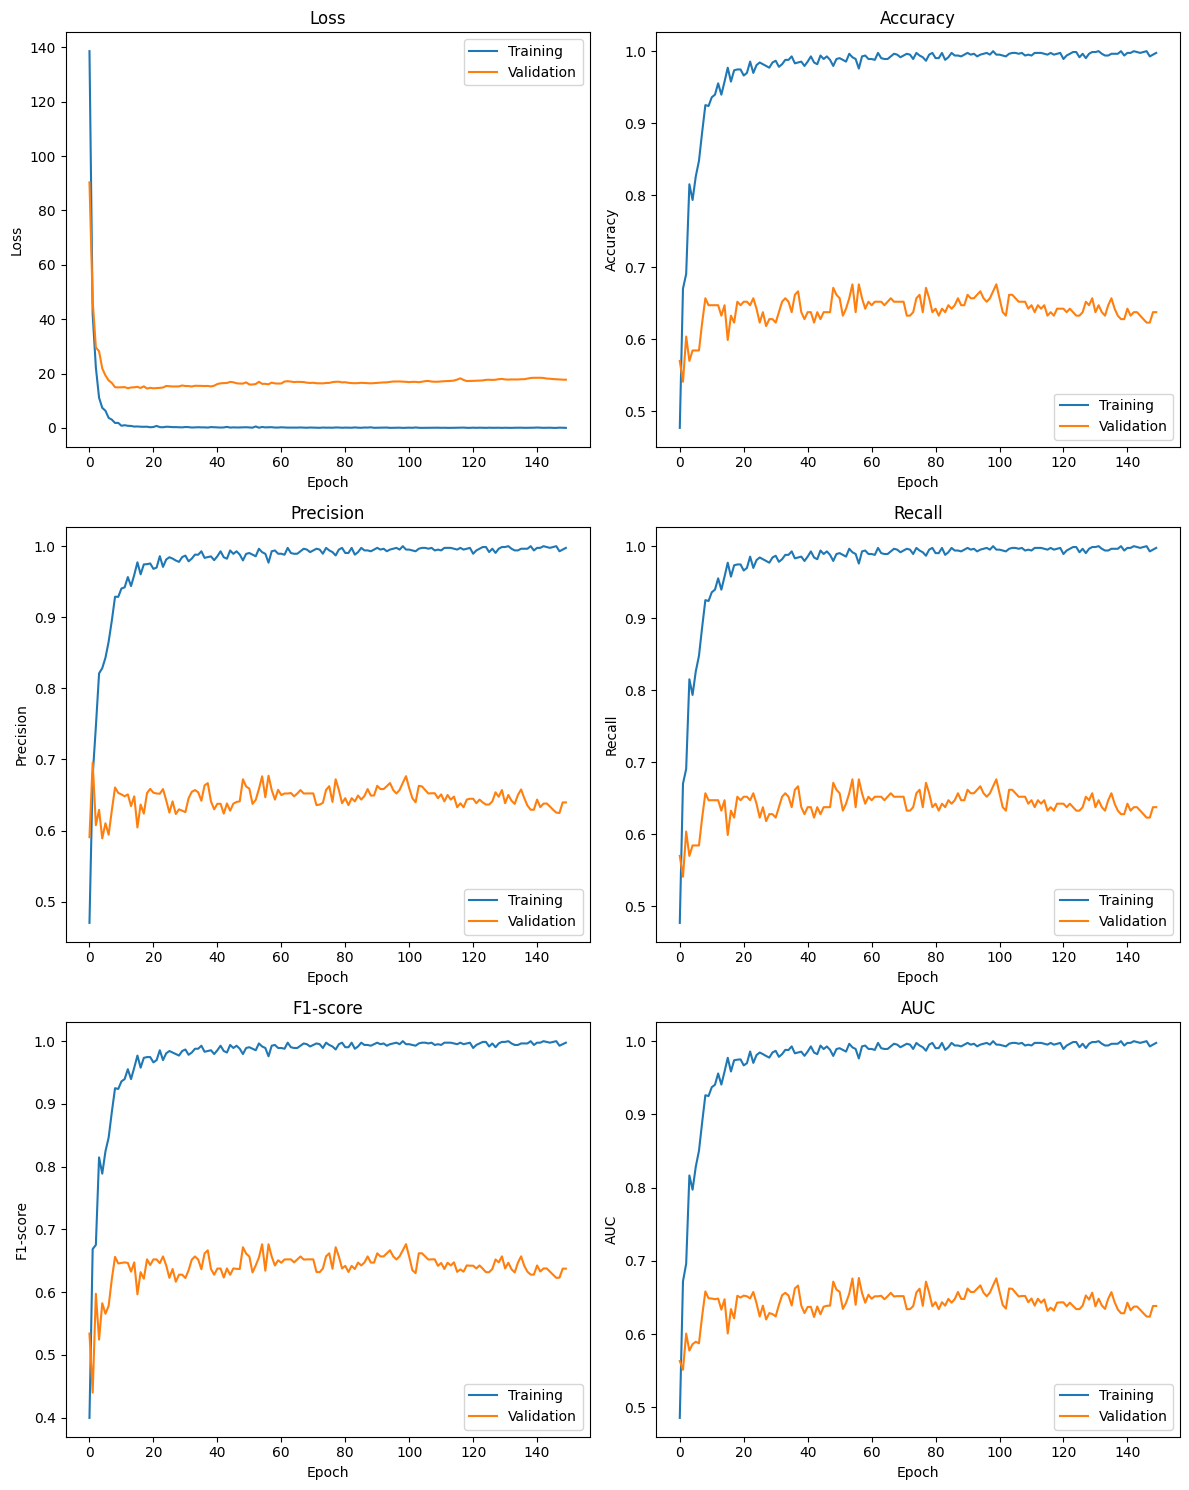

Testing...
Training time taken with pretrain : 215.59408712387085
Fold 0: Accuracy: 0.642512077294686
Fold 0: Confusion matrix:
[[62 39]
 [35 71]]


Test AUC,▁▂▅▆▄▇▇▅▆▆▇▆▆▇▇▇▇▇▇▆▇▆▆▇▇▇█▇▇▆▆▆▆▆▇▆▆▆▅▆
Test Accuracy,▁▃▅▇▄▇▇▅▆▆█▆▆▇▇▇▇▇▇▆▇▆▆▇▇▇█▇▇▆▆▆▆▆▇▆▆▆▆▆
Test F1-Score,▁▄▆▇▆▇▇▆▇▇█▇▇█▇▇▇▇▇▇█▇▇▇▇▇██▇▇▇▇▇▇▇▇▇▇▇▇
Test Loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▂▂▂▂▂▂▂▂▂▂▂▂
Test Precision,█▃▃▄▁▅▅▂▄▄▆▄▄▅▅▅▅▅▅▄▅▄▄▅▅▅▇▆▅▄▄▃▄▃▅▄▃▃▃▄
Test Recall,▁▃▅▇▄▇▇▅▆▆█▆▆▇▇▇▇▇▇▆▇▆▆▇▇▇█▇▇▆▆▆▆▆▇▆▆▆▆▆
Train AUC,▁▄▆▇█▇▇█████████████████████████████████
Train Accuracy,▁▄▆▇█▇▇█████████████████████████████████
Train F1-Score,▁▄▆▇█▇▇█████████████████████████████████
Train Loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Precision,▁▄▆▇█▇▇█████████████████████████████████


Fold 1

number of encoded layers: 2
Pretraining finished...


Epoch 149: 100%|██████████| 150/150 [03:49<00:00,  1.53s/epoch, acc=0.9879227053140096, loss=0.08101422549024306] 


best acc: 0.6956521739130435


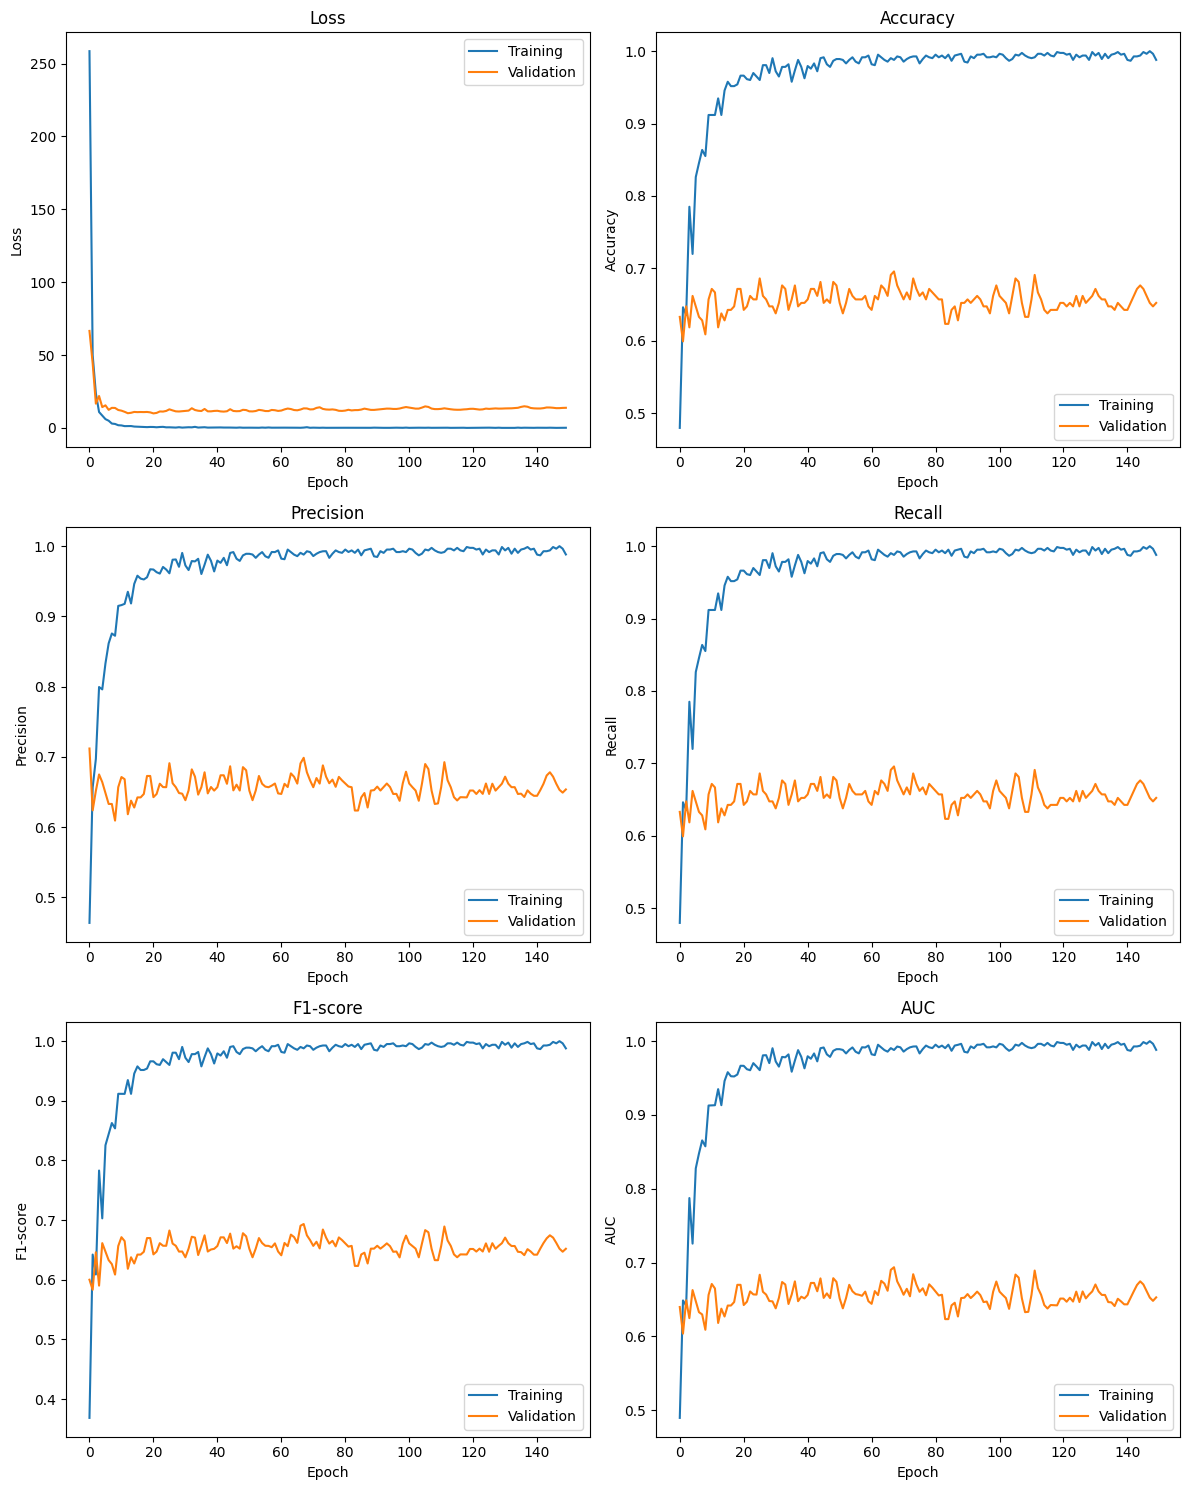

Testing...
Training time taken with pretrain : 230.4234528541565
Fold 1: Accuracy: 0.6763285024154589
Fold 1: Confusion matrix:
[[64 37]
 [30 76]]


Test AUC,▁▃▃▆▄▆▅▅▅▅▅▇▅▇▆▅▆▆▆█▆▆▃▃▅▅▇▄▅█▅▄▅▅▆▅▅▅▆▅
Test Accuracy,▁▂▃▆▄▇▅▅▅▅▅▇▅▇▇▅▆▆▆█▆▆▃▃▅▅▇▄▅█▅▄▅▅▆▅▅▅▇▅
Test F1-Score,▁▁▄▆▅▇▆▆▆▆▅▇▆▇▇▆▆▆▆█▆▆▄▄▆▅▇▅▆█▆▅▅▅▆▆▅▆▇▆
Test Loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▁▁▁▁▂▂▂▂▂▂
Test Precision,▁▆▂▆▃▆▄▄▄▄▃▆▄▇▆▅▅▅▅█▅▅▁▁▄▃▇▂▄█▄▃▃▃▅▄▄▄▆▄
Test Recall,▁▂▃▆▄▇▅▅▅▅▅▇▅▇▇▅▆▆▆█▆▆▃▃▅▅▇▄▅█▅▄▅▅▆▅▅▅▇▅
Train AUC,▁▄▅▆▇▇▇█▇▇██████████████████████████████
Train Accuracy,▁▄▅▆▇▇▇█▇▇██████████████████████████████
Train F1-Score,▁▄▅▆▇▇▇█▇▇██████████████████████████████
Train Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Precision,▁▄▅▆▇▇▇█▇▇██████████████████████████████


Fold 2

number of encoded layers: 2
Pretraining finished...


Epoch 2:   1%|▏         | 2/150 [00:07<06:02,  2.45s/epoch, acc=0.5978260869565217, loss=30.103207111358643]/Users/ram/Desktop/ASD detect/METAFormer-master/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 3:   2%|▏         | 3/150 [00:08<06:56,  2.83s/epoch, acc=0.5978260869565217, loss=30.103207111358643]/Users/ram/Desktop/ASD detect/METAFormer-master/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 3:   2%|▏         | 3/150 [00:09<06:56,  2.83s/epoch, acc=0.

best acc: 0.714975845410628


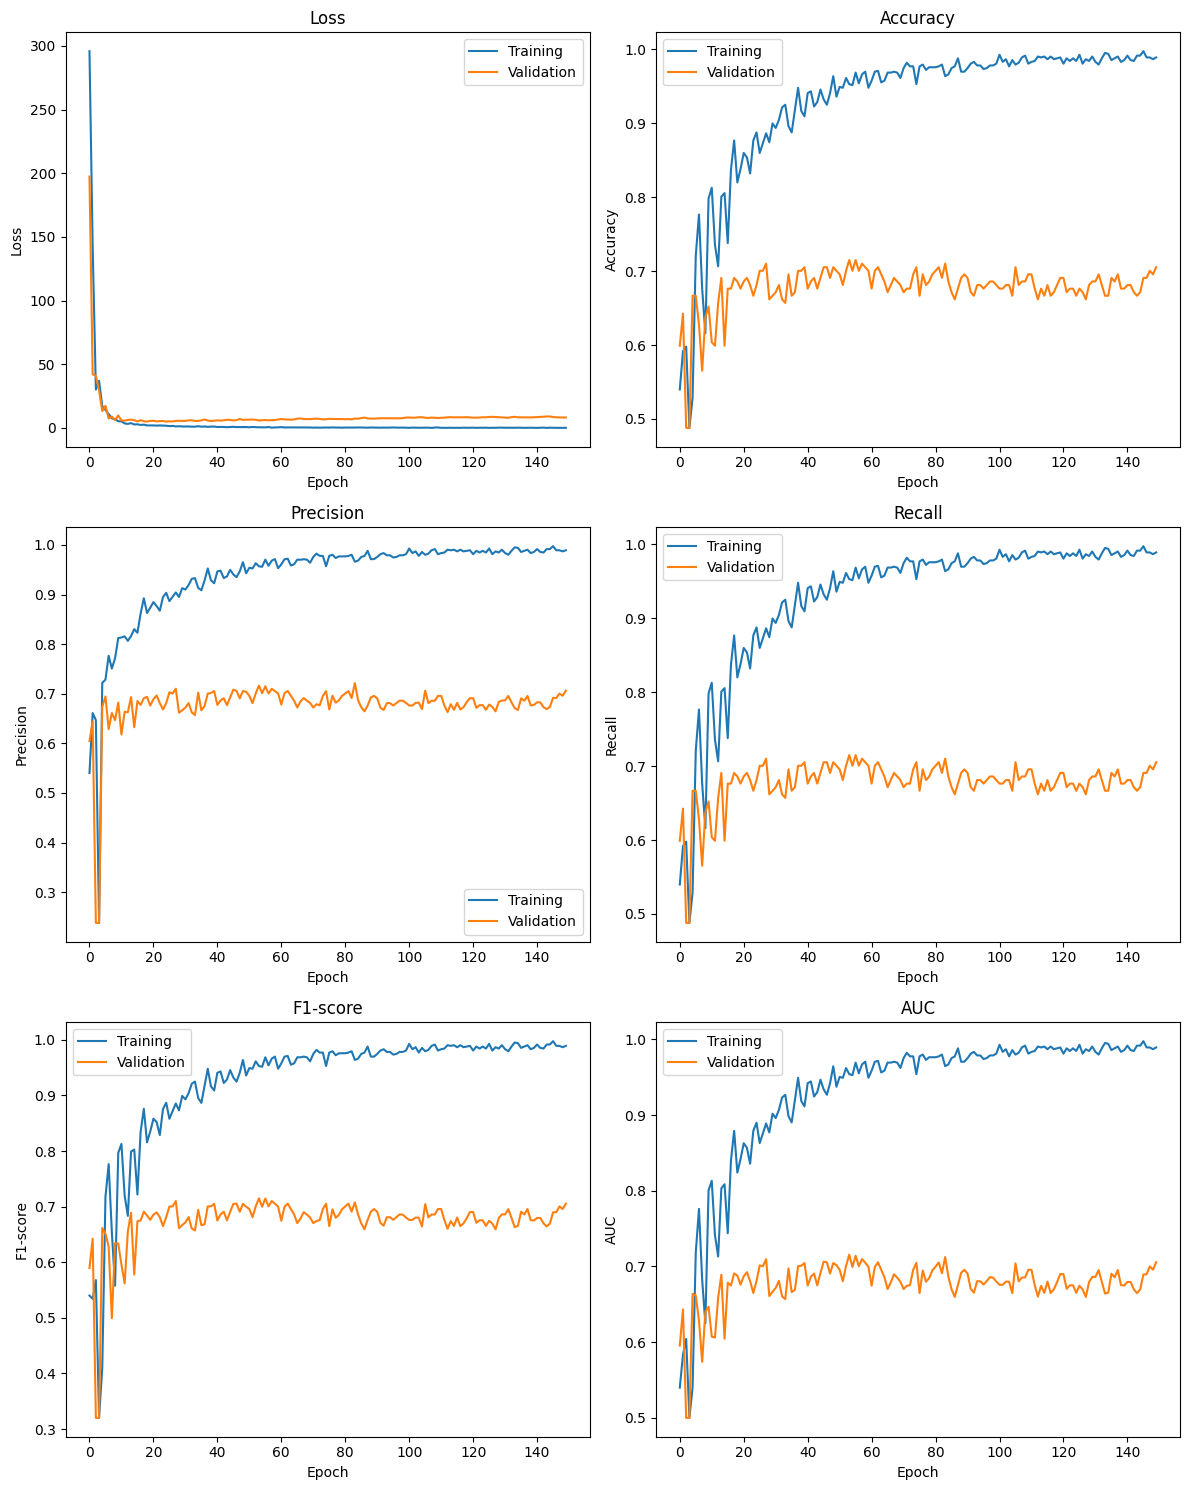

Testing...
Training time taken with pretrain : 259.57121205329895
Fold 2: Accuracy: 0.6666666666666666
Fold 2: Confusion matrix:
[[54 47]
 [22 84]]


Test AUC,▆▁▃▄▇▇▆█▇▆█▇████▇▇▇▇▆▇█▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇█
Test Accuracy,▆▁▃▄▇▇▇█▇▇█▇█████▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
Test F1-Score,▇▁▄▅▇▇▇█▇▇█▇█████▇▇█▇██▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██
Test Loss,█▆▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂
Test Precision,▇▁▇▇▇▇▇█▇▇█▇█████▇▇█▇██▇▇▇▇▇▇▇▇▇▇▇▇▇█▇██
Test Recall,▆▁▃▄▇▇▇█▇▇█▇█████▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█
Train AUC,▂▁▄▄▄▆▆▆▇▆▇▇▇▇▇█████████████████████████
Train Accuracy,▂▁▄▄▄▆▆▆▇▆▇▇▇▇▇█████████████████████████
Train F1-Score,▃▁▄▅▅▆▇▇▇▇▇▇▇▇██████████████████████████
Train Loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Precision,▅▁▆▆▆▇▇▇▇▇██▇▇██████████████████████████


Fold 3

number of encoded layers: 2
Pretraining finished...


Epoch 149: 100%|██████████| 150/150 [04:25<00:00,  1.77s/epoch, acc=0.9915458937198067, loss=0.10036700335331261] 


best acc: 0.6376811594202898


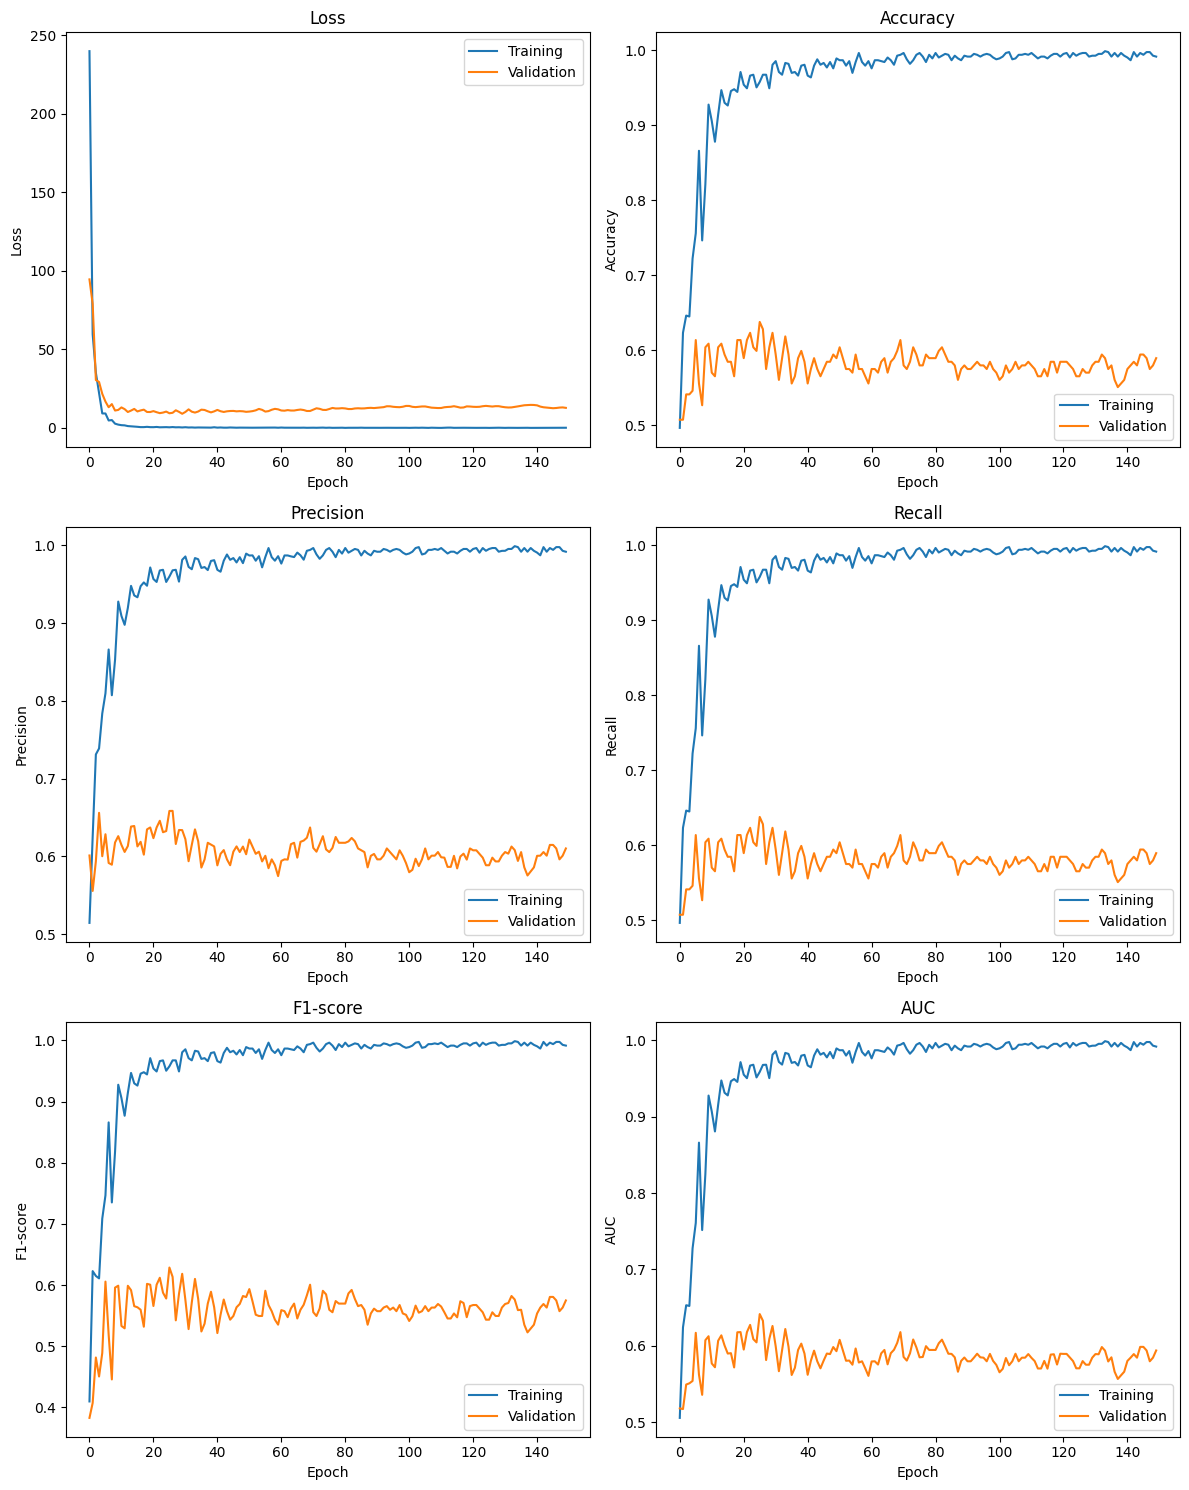

Testing...
Training time taken with pretrain : 265.6526551246643
Fold 3: Accuracy: 0.6183574879227053
Fold 3: Confusion matrix:
[[70 31]
 [48 58]]


Test AUC,▁▃▂▅▆█▇▅▄▄▆▅▅▆▅▅▅▅█▇▆▆▇▄▅▆▅▅▆▅▅▆▆▅▆▆▄▆▇▆
Test Accuracy,▁▃▂▅▆█▇▅▅▄▆▅▅▆▅▅▅▅█▇▆▆▇▅▅▆▅▅▆▅▅▆▆▅▆▆▄▆▇▆
Test F1-Score,▁▃▂▅▇██▆▅▅▇▆▆▇▆▆▆▆██▇▇▇▆▆▇▆▆▇▆▆▇▇▆▇▇▅▇▇▇
Test Loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Precision,▁█▃▄▅▇▆▅▄▃▅▄▅▄▅▄▄▄▇▆▄▅▅▃▄▄▃▃▄▄▃▄▅▃▄▅▂▄▅▅
Test Recall,▁▃▂▅▆█▇▅▅▄▆▅▅▆▅▅▅▅█▇▆▆▇▅▅▆▅▅▆▅▅▆▆▅▆▆▄▆▇▆
Train AUC,▁▂▃▆▇▇▇▇▇▇▇▇████████████████████████████
Train Accuracy,▁▁▃▆▇▇▇▇▇▇▇▇████████████████████████████
Train F1-Score,▁▁▃▆▇▇▇▇▇▇▇▇████████████████████████████
Train Loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Precision,▁▃▄▆▇▇▇▇█▇▇▇████████████████████████████


Fold 4

number of encoded layers: 2
Pretraining finished...


Epoch 1:   1%|          | 1/150 [00:03<05:17,  2.13s/epoch, acc=0.5833333333333334, loss=77.76782083511353] /Users/ram/Desktop/ASD detect/METAFormer-master/venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Epoch 149: 100%|██████████| 150/150 [04:34<00:00,  1.83s/epoch, acc=0.9891304347826086, loss=0.05752212321385741] 


best acc: 0.7101449275362319


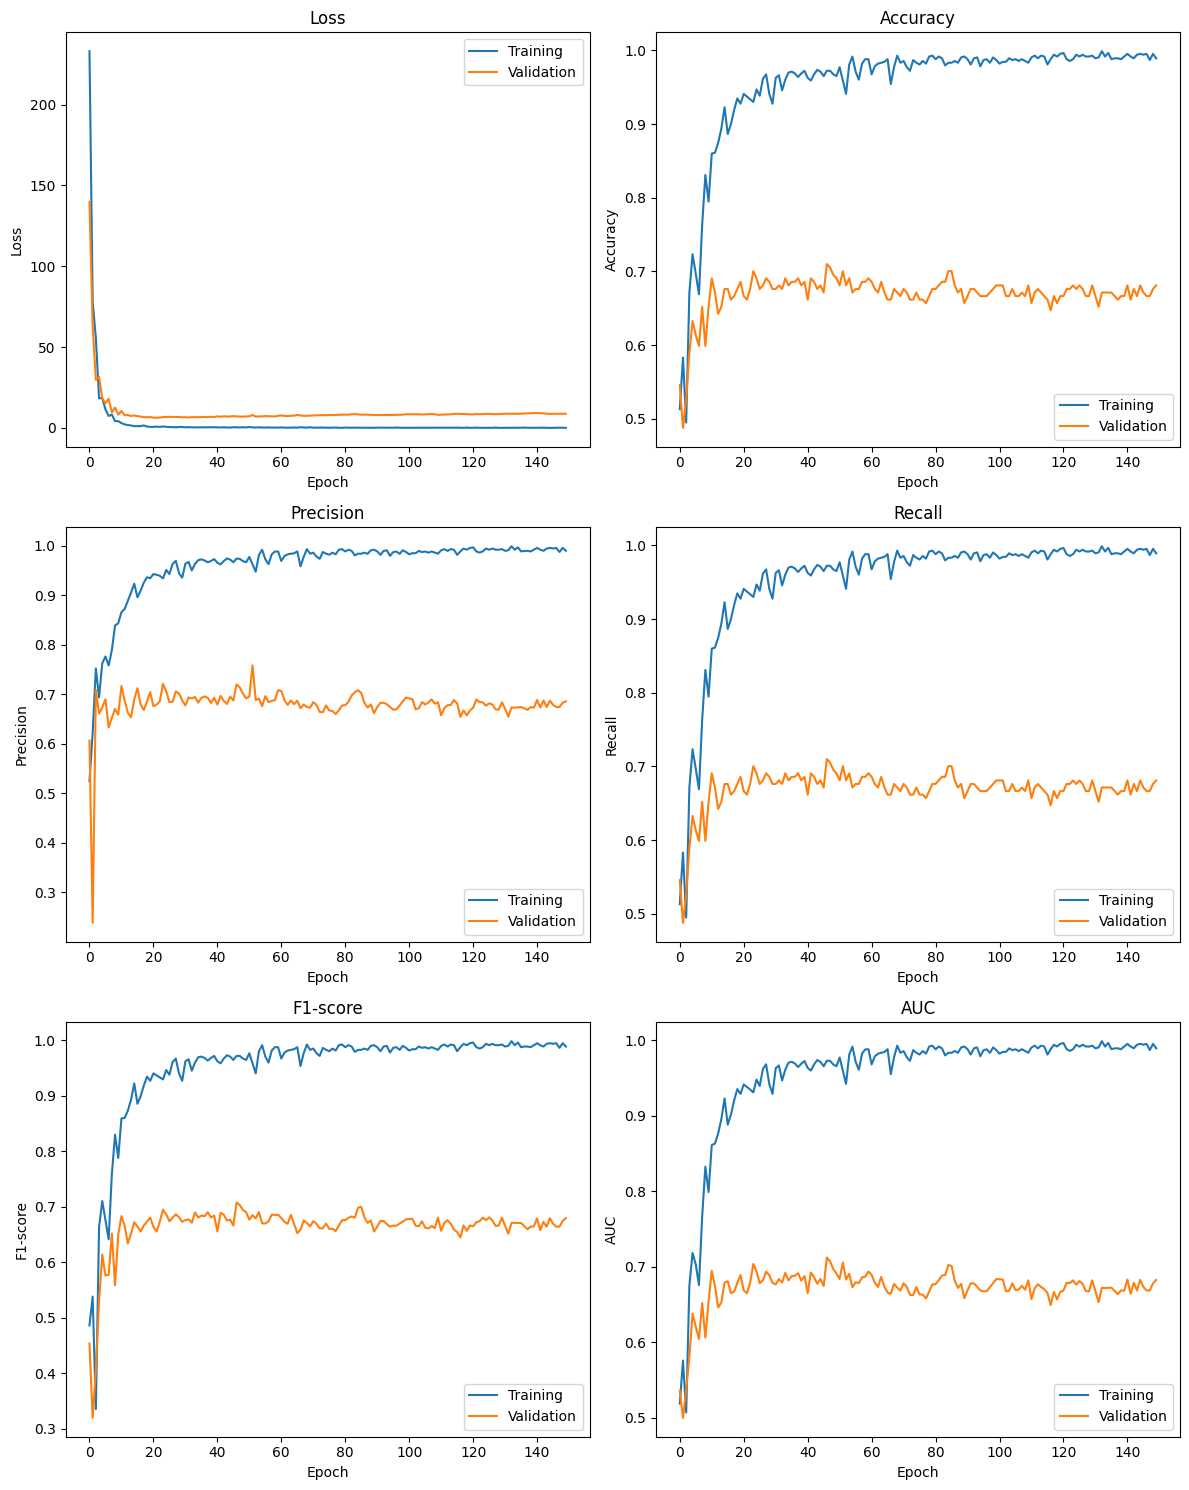

Testing...
Training time taken with pretrain : 274.89280366897583
Fold 4: Accuracy: 0.6618357487922706
Fold 4: Confusion matrix:
[[72 29]
 [41 65]]


Test AUC,▁▄▆▇▇▇██▇▇██▇██▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Test Accuracy,▁▄▆▇▇███▇███▇███▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Test F1-Score,▁▅▇▇▇███████▇████▇▇▇▇████▇█▇▇██▇████▇▇██
Test Loss,█▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Precision,▁▇▇████████████▇██▇▇▇▇█▇▇▇█▇█▇▇▇█▇▇▇▇▇▇▇
Test Recall,▁▄▆▇▇███▇███▇███▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Train AUC,▁▃▄▆▆▇▇████▇████████████████████████████
Train Accuracy,▁▃▄▆▆▇▇███▇▇████████████████████████████
Train F1-Score,▁▃▄▆▆▇▇████▇████████████████████████████
Train Loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Train Precision,▁▂▄▆▆▇▇█▇█▇▇▇▇██████████████████████████


   Fold  Num_fnet_layers  Accuracy  Precision    Recall        F1       AUC  \
0     0                2  0.642512   0.645455  0.669811  0.657407  0.641836   
1     1                2  0.676329   0.672566  0.716981  0.694064  0.675322   
2     2                2  0.666667   0.641221  0.792453  0.708861  0.663553   
3     3                2  0.618357   0.651685  0.547170  0.594872  0.620120   
4     4                2  0.661836   0.691489  0.613208  0.650000  0.663039   

         AP       FPR       FNR       TPR       TNR  
0  0.601415  0.386139  0.330189  0.669811  0.613861  
1  0.627145  0.366337  0.283019  0.716981  0.633663  
2  0.614418  0.465347  0.207547  0.792453  0.534653  
3  0.588467  0.306931  0.452830  0.547170  0.693069  
4  0.622094  0.287129  0.386792  0.613208  0.712871  
Mean accuracy: 0.6531400966183576
Std accuracy: 0.020586739857644958


In [51]:
pretrain_train_cross_validate(csv_file)

In [13]:
model = SAT(d_model=256, dim_feedforward=128, num_encoder_layers=2,
                           num_heads=4, dropout=cfg["DROP"]).to(cfg["DEVICE"])
print('Fnet model:')
model

Fnet model:


SAT(
  (encoder): EncoderBlock(
    (inp_emb): Linear(in_features=19900, out_features=256, bias=True)
    (encoder): FNet(
      (layers): ModuleList(
        (0-1): 2 x ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (fn): FNetBlock()
          )
          (1): PreNorm(
            (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (fn): FeedForward(
              (linear1): Linear(in_features=256, out_features=4, bias=True)
              (dropout): Dropout(p=0.8, inplace=False)
              (linear3): Linear(in_features=4, out_features=256, bias=True)
              (dropout1): Dropout(p=0.8, inplace=False)
              (dropout2): Dropout(p=0.8, inplace=False)
              (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
              (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            )
          )
        )
      )
    )
  )
  (act): GELU(approxim

In [14]:
print('FNet model')
print("-"*40)
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters : {total_params}")
total_trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of trainable parameters in model: {total_trainable_parameters}")

FNet model
----------------------------------------
Number of parameters : 5103882
Total number of trainable parameters in model: 5103882


In [15]:
# device = cfg["DEVICE"]

# df = pd.read_csv(csv_file)

# # cross validation
# kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# y = df.LABELS
# x = df.drop("LABELS", axis=1)
# accs = []

# table_cols = ['Fold', 'Accuracy', 'Precision', 'Recall',
#               'F1', 'AUC', 'AP', 'FPR', 'FNR', 'TPR', 'TNR']

# vals = []

# for fold, (train_idx, test_idx) in enumerate(kfold.split(x, y)):
#     print(80 * "=")
#     print(f"Fold {fold}")
#     print(80 * "=")

#     train_df, val_df = train_test_split(
#         df.iloc[train_idx], test_size=0.3, random_state=42)
#     test_df = df.iloc[test_idx]

#     # print(f'len of train_df: {len(train_df)},,{train_df.shape}')

#     train_loader = DataLoader(MultiAtlas(
#         train_df, augment=0.3), batch_size=cfg["BATCH_SIZE"], shuffle=True, num_workers=0, pin_memory=True)
#     val_loader = DataLoader(MultiAtlas(
#         val_df, augment=0.3), batch_size=cfg["BATCH_SIZE"], shuffle=False, num_workers=0, pin_memory=True)
#     test_loader = DataLoader(MultiAtlas(
#         test_df, augment=0.3), batch_size=cfg["BATCH_SIZE"], shuffle=False, num_workers=0, pin_memory=True)

#     # Pretrain
#     pretrain_loader = DataLoader(ImputationDataset(
#         train_df), batch_size=cfg["BATCH_SIZE"], shuffle=True, num_workers=0, pin_memory=True)
#     preval_loader = DataLoader(ImputationDataset(
#         val_df), batch_size=cfg["BATCH_SIZE"], shuffle=False, num_workers=0, pin_memory=True)

#     pt_model = METAWrapper(d_model=256, dim_feedforward=128, num_encoder_layers=2,
#                             num_heads=4, dropout=cfg["DROP"]).to(cfg["DEVICE"])

#     pt_optim = optim.AdamW(pt_model.parameters(),
#                             lr=cfg["LR"], weight_decay=cfg["WEIGHT_DECAY"])

#     # print(pt_model)
#     # print(f"pretrain loader shape: {len(pretrain_loader)}")

#     pretrained = pretrain(model=pt_model, train_loader=pretrain_loader, val_loader=preval_loader,
#                           optimizer=pt_optim, epochs=1000, device=device, stage=f"pretrain fold {fold}", patience=3, scheduler=None)

#     print("Pretraining finished...")
#     print(pretrained)


#     # Load pretrained weights
#     model = METAFormer(d_model=256, dim_feedforward=128, num_encoder_layers=2,
#                         num_heads=4, dropout=cfg["DROP"]).to(cfg["DEVICE"])
#     model.aal_encoder.load_state_dict(
#             pretrained.aal_encoder.state_dict())
#     model.cc200_encoder.load_state_dict(
#         pretrained.cc200_encoder.state_dict())
#     model.dos160_encoder.load_state_dict(
#         pretrained.dos160_encoder.state_dict())

#     optimizer = optim.AdamW(
#         model.parameters(), lr=cfg["LR"], weight_decay=cfg["WEIGHT_DECAY"])

#     scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
#     criterion = nn.BCEWithLogitsLoss().to(cfg["DEVICE"])

#     trained_model, best_a = train(model, train_loader, val_loader, criterion, optimizer,
#                                   cfg["EPOCHS"], device, patience=cfg["PATIENCE"], scheduler=scheduler, return_best_acc=True)

#     # Test
#     print("Testing...")
#     trues, preds = test(trained_model, test_loader, device)

#     acc = accuracy_score(trues, preds)
#     accs.append(acc)
#     cm = confusion_matrix(trues, preds)
#     precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
#     recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
#     f1 = 2 * (precision * recall) / (precision + recall)
#     auc = roc_auc_score(trues, preds)
#     ap = average_precision_score(trues, preds)
#     fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])
#     fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])
#     tpr = cm[1, 1] / (cm[1, 1] + cm[1, 0])
#     tnr = cm[0, 0] / (cm[0, 0] + cm[0, 1])

#     print(f"Fold {fold}: Accuracy: {acc}")
#     print(f"Fold {fold}: Confusion matrix:\n{cm}")

#     vals.append([fold, acc, precision, recall,
#                   f1, auc, ap, fpr, fnr, tpr, tnr])

# results = pd.DataFrame(vals, columns=table_cols)
# print(results)
# print(80 * "=")
# print(f"Mean accuracy: {np.mean(accs)}")
# print(f"Std accuracy: {np.std(accs)}")



In [16]:
print(pretrained.dos160_encoder.state_dict())

NameError: name 'pretrained' is not defined